In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from renderer import Renderer

In [2]:
%%time
m,n,p = 100,101,102
sphere = np.zeros((p, m,n))
for i in range(m) :
    for j in range(n) :
        for k in range(p) :
            v = np.array([i,j,k])
            d = v - np.array([20,10,10])
            d2 = v - np.array([30,39,20])
            if np.sum(d*d) < 10 or np.sum(d2*d2) < 10 :
                sphere[k, i,j] = 1

sphere[1:5,1:5,1:5] = 1

CPU times: user 11 s, sys: 1.57 ms, total: 11 s
Wall time: 11 s


In [3]:
renderer = Renderer(120,150, 150)

CPU times: user 11.2 s, sys: 811 ms, total: 12 s
Wall time: 3.24 s


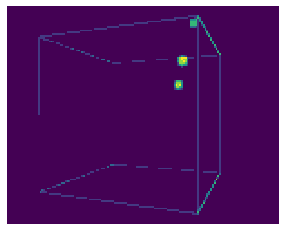

In [4]:
%%time
ims = []
array = sphere
center = (np.array([p,m,n])-1)/2
fig = plt.figure()
t = 0

for i in range(100) :
    camera_pos = center +200*np.array([-np.cos(t),0,-np.sin(t)])
    plt.axis('off')
    res = renderer(sphere, camera_pos)
    ims.append([plt.imshow(res, animated=True)])
    t += 3.14150*2/100

In [5]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())